## MTH 9875 The Volatility Surface:    Fall 2016

<p>
### Lecture 7: Stochastic volatility with jumps, time-changed Lévy models


Jim Gatheral   
Department of Mathematics   
  
  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2016/04/MFE-Logo.jpg" align = "right" width=500></h3>

### Outline of lecture 7

- Stochastic volatility plus stock price jumps (SVJ)

- Stochastic volatility with stock and volatility jumps (SVJJ)

- Comparison of model fits

- The Schoutens et al. paper

- Stochastic time change

- Valuation of the guaranteed stop-loss contract

### Stochastic volatility plus stock price jumps (SVJ)

Since jumps generate a steep short-dated skew that dies quickly with
time to expiration and stochastic volatility models don’t generate
enough skew for very short expirations but more or less fit for longer
expirations, it is natural to try to combine stock price jumps and
stochastic volatility in one model.
- <span> In passing, we give explicit characteristic functions for the
popular SVJ and SVJJ models:</span>

    - <span>The SVJ model succeeds in generating a volatility surface that has
most of the observed features of the empirical surface with fewer
parameters than the SVJJ model.</span>

### SVJ process

Suppose we add a simple Merton-style lognormally distributed jump
process to the Heston process so that

\begin{eqnarray*}
dS &=& \mu \, S\, dt +  \sqrt{v}\,S\, dZ_1 +\left(e^{\alpha+\delta\,\epsilon}-1\right)\,S\,dq\\
dv &=&  - \lambda (v - \bar v)\,dt + \eta \,\sqrt {v}\, dZ_2
\end{eqnarray*}

with $ \left\langle {dZ_1 \,{dZ_2} } \right\rangle = \rho \,{ dt}$,
$\epsilon \sim N(0,1)$ and as in the jump-diffusion case, the Poisson
process

$$dq=
\left\{ {\begin{array}{*{10}l}
   &0&\textrm{ with probability }1- \lambda_J\, dt  \\
   &1&\textrm{ with probability } \lambda_J \, dt \\
\end{array}}
\right.$$

where $\lambda_J$ is the jump intensity (or hazard rate).

### Reminder: Computing the ATM volatility level and skew

We recall the following formulae from Lecture 6:

<a name="eq:ImpliedFromFourier"></a>(1)
$$
\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
\,\mathrm{Re}\left[e^{-iuk}\left(\phi_T\left(u-i/2\right)-e^{-\frac{1}{2}\left(u^2+\frac{1}{4}\right)\sigma_{BS}^2
T }\right)\right]=0$$

and

<a name="eq:skew"></a>(2)
$$\left.\frac{\partial \sigma_{BS} }{\partial k }\right|_{k=0}=-
e^{\frac{\sigma_{BS}^2 T}{8}} \sqrt{\frac{2}{ \pi}}\frac{1}{
\sqrt{T}}\,\int_0^\infty\,du \, \frac{u\,
\mathrm{Im}\left[\phi_T(u-i/2)\right]}
{u^2+\frac{1}{4}}$$

- Given a characteristic function in closed-form, we may easily compute
the ATM volatility and the ATM volatility skew.

### SVJ characteristic function

By substitution into the valuation equation, it is easy to see that the
characteristic function for the SVJ process is just the product of
Heston and jump characteristic functions. Specifically,

<a name="eq:phiSVJ"></a>(3)
$$\phi_T(u) =e^{C(u,T)\,\bar v+D(u,T)\,v} \,e^{\psi(u) T}$$

with
$\psi(u)=-\lambda_J i u \left(e^{\alpha +\delta^2/2
}-1\right)+\lambda_J\left( e^{i u \alpha-u^2 \delta^2/2 }-1
\right)$ and $C(u,T)$, $D(u,T)$ are as before.

We may substitute this functional form into equations [(1)](#eq:ImpliedFromFourier) and [(2)](#eq:skew) to get the
implied volatilities and at-the-money volatility skew respectively for
any given expiration.

### Term structure of SVJ skew

- <span> [Figure 1](#fig:combskew) plots the at-the-money variance skew
corresponding to the Bakshi-Cao-Chen SVJ model fit together with the sum
of the Heston and jump-diffusion at-the-money variance skews with the
same parameters (see [Table 1](#table:jumpfits)).</span>

- <span> We see that (at least with this choice of parameters), not only
does the characteristic function factorize but the at-the-money variance
skew is almost additive. </span>

- <span>One practical consequence of this is that the Heston parameters
can be fitted fairly robustly using longer dated options and then jump
parameters can be found to generate the required extra skew for
short-dated options. </span>

- <span>[Figure 2](#fig:shortdatedskew) plots the at-the-money variance skew
corresponding to the SVJ model vs the Heston model skew for short-dated
options, highlighting the small difference.</span>

### Download some R code

In [1]:
download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/10/9875-7.zip", destfile="9875-7.zip")
unzip(zipfile="9875-7.zip")

library(stinepack)

source("BlackScholes.R") 
source("svi.R") 
source("sviVolSurface.R") 
source("Heston2.R")

### SVJ ATM skew

Recall our BCC parameters:

In [2]:
subSVJJ <- list(lambda = 2.03,eta = 0.38, rho = -0.57, vbar = 0.04,v = .04, 
                lambdaJ = 0.59, alpha = -0.05, delta = 0.07, gammaV = 0.1) 

Now we code the SVJ characteristic function from equation [(3)](#eq:phiSVJ) above:

In [3]:
phiSVJ <- function(params){
    
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    
    function(u, t){
        psiu <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))   
        return(phiHeston(params)(u,t)*exp(psiu*t)) 
        }
}

And code formula [(2)](#eq:skew) to get the ATM volatility skew from the characteristic function (Equation (5.8) of The Volatility Surface, equation (8) of Lecture 6):

In [4]:
atmSkew <- function(phi, t){
    atmVol <- BSImpliedVolCall(S0=1, K=1, T=t, r=0, C=callOption(phi, 0, t)) 
    integrand <-  function(u){Im(u*phi(u - 1i/2, t)/(u^2 + 1/4))} 
    res <- -integrate(integrand,lower=0,upper=Inf,rel.tol=0.0000000001,subdivisions=1000)$value/sqrt(t)*sqrt(2/pi)*exp(atmVol^2*t/8) 
    return(res) 
}

# Vectorize the function
atmSkewV <- function(phi,tVec){sapply(tVec,function(t){atmSkew(phi,t)})} 
#curve(atmSkewV(phiHeston(subSVJJ),x),from=.01,to=10,col="red")


# Now variance skew
atmVarSkew <- function(phi, t){
    volSkew <- atmSkew(phi,t) 
    atmVol <- bsvol(phi,0,t) 
    return(2*volSkew*atmVol) 
}

# Vectorize the function
atmVarSkewV <- function(phi,tVec){sapply(tVec,function(t){atmVarSkew(phi,t)})} 

To construct the SVJ characteristic function, we need to code the Merton jump-diffusion characteristic function (see Lecture 6 again):

In [5]:
phiMJD <- function(params){
    
    sigma <- params$sigma 
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    
    function(u, t){

    psiBS <- -u/2*(u+1i)*sigma^2 
    psiJump <- lambdaJ*(-1i*u*(exp(alpha+delta^2/2)-1) + (exp(1i*u*alpha-u^2*delta^2/2)-1))   
        
    return(exp((psiBS+psiJump)*t)) 
}
}

We now verify that the SVJ skew almost perfectly decomposes as sum of Heston skew and jump skew:

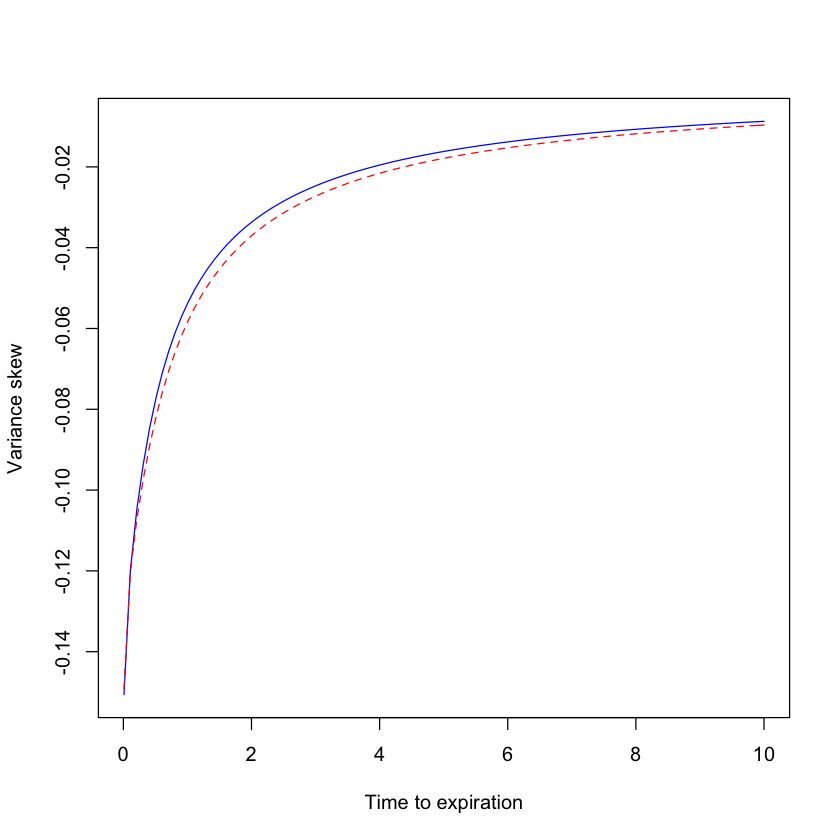

In [6]:
parHestJD <- list(lambda = 2.03,eta = 0.38, rho = -0.57, vbar = 0.04,v = .04, 
                lambdaJ = 0.59, alpha = -0.05, delta = 0.07, gammaV = 0.1, sigma=.2) 

skewSum <- function(x){atmVarSkewV(phiHeston(parHestJD),x)+atmVarSkewV(phiMJD(parHestJD),x)}

curve(atmVarSkewV(phiSVJ(parHestJD),x),from=.01,to=10,col="blue",ylab="Variance skew", xlab="Time to expiration")
curve(skewSum(x),from=.01,to=10,col="red",add=T,lty=2)

<a name="fig:combskew"></a>Figure 1: The solid line is a graph of the at-the-money variance skew in the SVJ
model with BCC parameters vs time to expiration. The dashed line
represents the sum of at-the-money Heston and jump-diffusion skews with
the same parameters.

### SVJ skew vs Heston skew

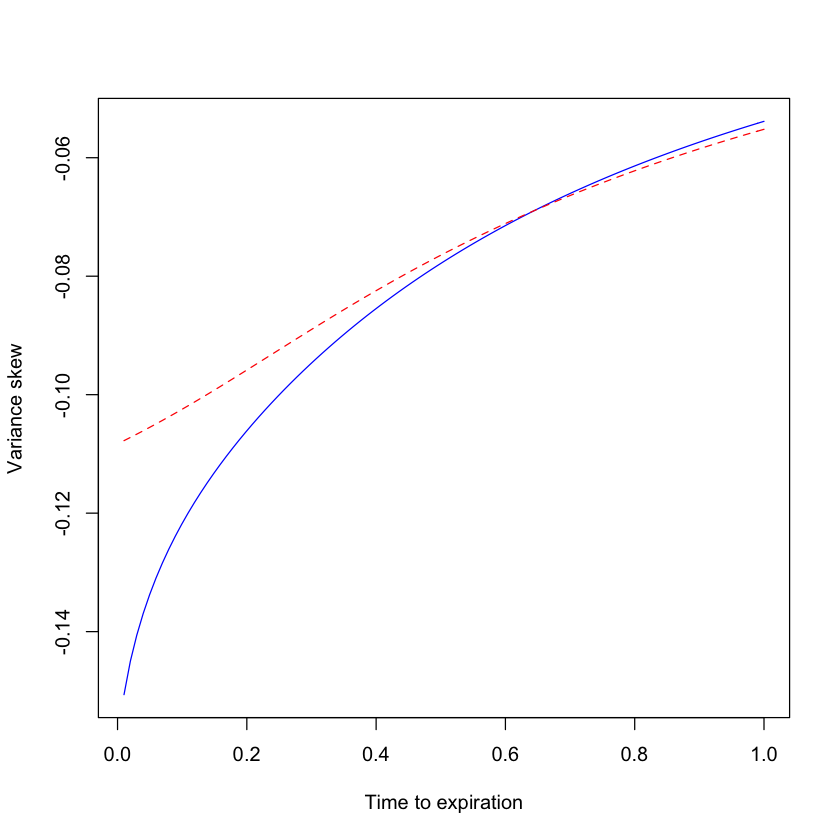

In [7]:
curve(atmVarSkewV(phiSVJ(subSVJJ),x),from=.01,to=1,col="blue",ylab="Variance skew", xlab="Time to expiration")
curve(atmVarSkewV(phiHeston(subSVJJ),x),from=.01,to=1,col="red",add=T,lty=2)

<a name="fig:shortdatedskew"></a>Figure 2: The solid line is a graph of the at-the-money variance skew in the SVJ
model with BCC parameters vs time to expiration. The dashed line
represents the at-the-money Heston skew with the same
parameters.

### SVJ model assumptions are unrealistic

- <span> In the SVJ model, after the stock price has jumped, the
volatility will stay unchanged because the jump process is uncorrelated
with the volatility process.</span>

    - <span> This is inconsistent with both intuition and empirically observed
properties of the time series of asset returns.</span>

    - <span>In practice, after a large move in the underlying, implied
volatilities always increase substantially (*i.e.* they jump).</span>

### Remarks on fitting SVJ

There are only 4 parameters in the jump-diffusion model: the volatility
$\sigma$, $\lambda_J$, $\alpha$ and $\delta$ so it’s not in principle
difficult to perform a fit to option price data. The SVJ model obviously
fits the data better because it has more parameters and it’s not
technically that much harder to perform the fit.

### Some empirical fits to the SPX volatility surface


| Author(s) | Model |   $\mathbf{\lambda}$   |   $\mathbf{\eta}$   |  $\mathbf{\rho}$     |   $\bar v$    |   $\mathbf{\lambda_J}$    |    $\mathbf{\alpha}$     |     $\mathbf{\delta}$   |
|-----------|------|-----:|-----:|------:|------:|------:|--------:|-------:|
| AA        |    JD |   NA |   NA |    NA | 0.032 | 0.089 | -0.8898 | 0.4505 |
| BCC       |   SVJ | 2.03 | 0.38 | -0.57 |  0.04 |  0.59 |   -0.05 |   0.07 |
| M         |   SVJ |  1.0 |  0.8 |  -0.7 |  0.04 |   0.5 |   -0.15 |      0 |
| DPS       |   SVJ | 3.99 | 0.27 | -0.79 | 0.014 |  0.11 |   -0.12 |   0.15 |
| JG        |   SVJ | 0.54 |  0.3 |  -0.7 | 0.044 |  0.13 |   -0.12 |   0.10 |

| Author(s) | Reference                      | Data from            |
|-----------|--------------------------------|----------------------|
| AA        | Andersen & Andreasen (2000)    | April 1999           |
| BCC       | Bakshi, Cao & Chen (1997)      | June 1988 – May 1991 |
| M         | Matytsin (1999)                | 1999                 |
| DPS       | Duffie, Pan & Singleton (2000) | November 1993        |
| JG        | Jim G.                         | September 2005       |

<a name="table:jumpfits"></a>
Table 1: Various fits of jump-diffusion style models to SPX data. JD means Jump Diffusion and SVJ means Stochastic Volatility plus Jumps.

### Remarks on the fits

- <span>These estimates all relate to different dates.</span>

    - <span>We can’t expect the volatility surfaces they generate to be the
same shape.</span>

- <span> Nevertheless, the shape of the SPX volatility surface doesn’t
really change much over time so it does make some sense to compare
them.</span>

### A remark on the AA estimate

The one estimate that sticks out is obviously the AA JD fit with a huge
expected jump size of $-0.8898$. At first sight it might seem
disconcerting that imputing jump parameters from implied volatility
surfaces could give rise to such wildly different parameter estimates.

- <span>The AA jump size estimate turns out to have been driven by
requiring the fit to match the 10-year volatility skew</span>

    - <span>As pointed out earlier in Lecture 6, for the characteristic time $T^*$ to be of
the order of ten years, we need a huge jump size.</span>

- <span>The overall AA fit of JD to the implied volatility surface is very
poor.</span>

    - <span> JD is completely misspecified and we can confidently reject JD
with AA parameters.</span>

### Stochastic volatility with simultaneous jumps in stock price and volatility (SVJJ)

- <span>As we noted earlier in our discussion of the SVJ model, it is
unrealistic to suppose that the instantaneous volatility wouldn’t jump
if the stock price were to jump.</span>

- <span> Conversely, adding a simultaneous upward jump in volatility to
jumps in the stock price allows us to maintain the clustering property
of stochastic volatility models: recall that “large moves follow large
moves and small moves follow small moves”.</span>

### The SVJJ model

- <span>In a couple of presentations, Andrew Matytsin describes a model
that is effectively SVJ with a jump in volatility:</span>

    - <span>Jumps in the stock price are accompanied by a jump
$v \mapsto v+\gamma_v$ in the instantaneous volatility.</span>

### The SVJJ characteristic function

The SVJJ characteristic function is given by

<a name="eq:SVJJcharfn"></a>(4)
$$\phi_T(u)= \exp\left\{\hat C(u,T)\,\bar v+\hat
D(u,T)\,v\right\}$$

with $C(u,T)$ and $D(u,T)$ given by

\begin{eqnarray*}
\hat C(u,T)&=&C(u,T)\\&&+\lambda_J\, T \,\left[e^
{iu\alpha-u^2\delta^2/2}I(u,T)-1-i\,u\,\left(e^{\alpha+\delta^2/2}-1\right)\right]\\
\hat D(u,T)&=&D(u,T)\end{eqnarray*}

where

\begin{eqnarray*}
I(u,T)&=&\frac{1}{T}\int_0^T{e^{\gamma_v D(u,t)}dt}\\
&=&-\frac{1}{T}\,\frac{2 \gamma_v}{p_+ p_-}\int_0^{-\gamma_v
D(u,T)}{\frac{e^{-z}dz}{(1+z/p_+)(1+z/p_-)}}\end{eqnarray*}

and $$p_\pm =\frac{\gamma_v}{\eta^2}(\beta-\rho \eta u i \pm d)$$

### Asymptotics of the SVJJ model

- <span> In the limit $\gamma_v\rightarrow 0$, we have
$I(u,T)\rightarrow 1$ and by inspection, we retrieve the SVJ
model.</span>


- <span> Also, in the limit $T\rightarrow 0$, $I(u,T)\rightarrow 1$ and in
that limit, the SVJJ characteristic function is identical to the SVJ
characteristic function.</span>

- <span> Alternatively, following our earlier heuristic argument, the
short-dated volatility skew is a function of the jump compensator only
and this compensator is identical in the SVJ and SVJJ cases. </span>

    - <span>Intuitively, when the stock price jumps, the volatility jumps but
this has no effect in the $T\rightarrow 0$ limit because by assumption,
an at-the-money option is always out-of-the-money after the jump and its
time value is zero no matter what the volatility is.</span>


- <span>On the other hand, in the $T\rightarrow \infty$ limit, the skew
should increase because the effective volatility of volatility increases
due to (random) jumps in volatility.</span>

### SVJJ ATM skew

Let's now code the SVJJ characteristic function.

In [8]:
phiSVJJ <- function(params){
    
    lambda <- params$lambda 
    rho <- params$rho 
    eta <- params$eta 
    vbar <- params$vbar 
    v <- params$v 
    lambdaJ <- params$lambdaJ 
    alpha <- params$alpha 
    delta <- params$delta 
    gammaV <- params$gammaV 
    
    function(u, t){

    al <- -u*u/2 - 1i*u/2 
    bet <- lambda - rho*eta*1i*u 
    gam <- eta^2/2 
    d <- sqrt(bet*bet - 4*al*gam) 
    rp <- (bet + d)/(2*gam) 
    rm <- (bet - d)/(2*gam) 
    g <- rm / rp 
    D <- rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t)) 
    Dfunc <- function(t){rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t))} 
    C <- lambda * (rm * t - 2/eta^2 * log( (1 - g*exp(-(d*t)))/(1 - g) ) ) 
    
    pplus <- gammaV/eta^2*(bet- rho*eta*u*1i + d) 
    pminus <- gammaV/eta^2*(bet- rho*eta*u*1i - d) 
    
    integrandR <- function(t){Re(exp(gammaV*Dfunc(t)))} 
    integrandI <- function(t){Im(exp(gammaV*Dfunc(t)))} 
    
    bigI <- 1/t*(integrate(integrandR,lower=0,upper=t,rel.tol=0.0000000001,subdivisions=1000)$value+
                 1i*integrate(integrandI,lower=0,upper=t,rel.tol=0.0000000001,subdivisions=1000)$value) 
    psi <- lambdaJ*t*( (exp(1i*u*alpha-u^2*delta^2/2)*bigI -1)-1i*u*(exp(alpha+delta^2/2)-1))
    
    return(exp(C*vbar + D*v + psi)) 
    }
}

### Plot the term structure of at-the-money volatility skew with BCC parameters for the various models 

Let's compare the ATM vol skew term structure for Heston, SVJ and SVJJ models.  To add the SVJJ curve, we need to explicitly vectorize the function:

In [9]:
f <- function(u,t){sapply(u,function(u){phiSVJJ(subSVJJ)(u,t)})}
sk <- function(t){sapply(t,function(x){atmSkewV(f,x)})}

Note that SVJJ comptutations are very slow!!

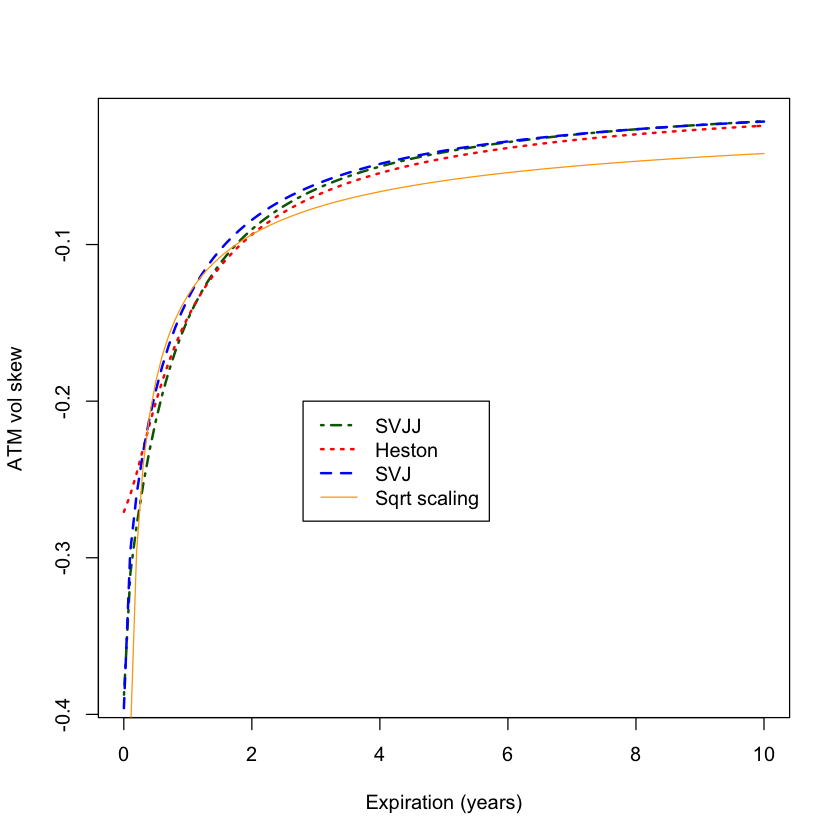

In [10]:
curve(sk(x),from=0.003,to=10,col="dark green",type="l",lwd=2,lty=4,ylab="ATM vol skew",xlab="Expiration (years)") 
curve(atmSkewV(phiHeston(subSVJJ),x),from=.001,to=10,col="red",lty=3,lwd=2,add=T) 
curve(atmSkewV(phiSVJ(subSVJJ),x),from=.001,to=10,col="blue",lty=2,lwd=2,add=T)

# Compare with sqrt(t) scaling
skew2 <- atmSkew(phiHeston(subSVJJ),2) 
curve(skew2/sqrt(x/2),from=.001,to=10,col="orange",ylim=c(-.4,0),add=T)

leg.txt <- c("SVJJ","Heston", "SVJ", "Sqrt scaling") 
legend(x=2.8,y=-.2,leg.txt,lty=c(4,3,2,1),col=c("dark green","red","blue","orange"),lwd=c(2,2,2,1))

<a name="fig:combskewSVJJ"></a>Figure 3: Term structure of at-the-money volatility skew with BCC parameters for
various models

### SVJJ ATM skew for short dates

Now a zoomed version of Figure 3:

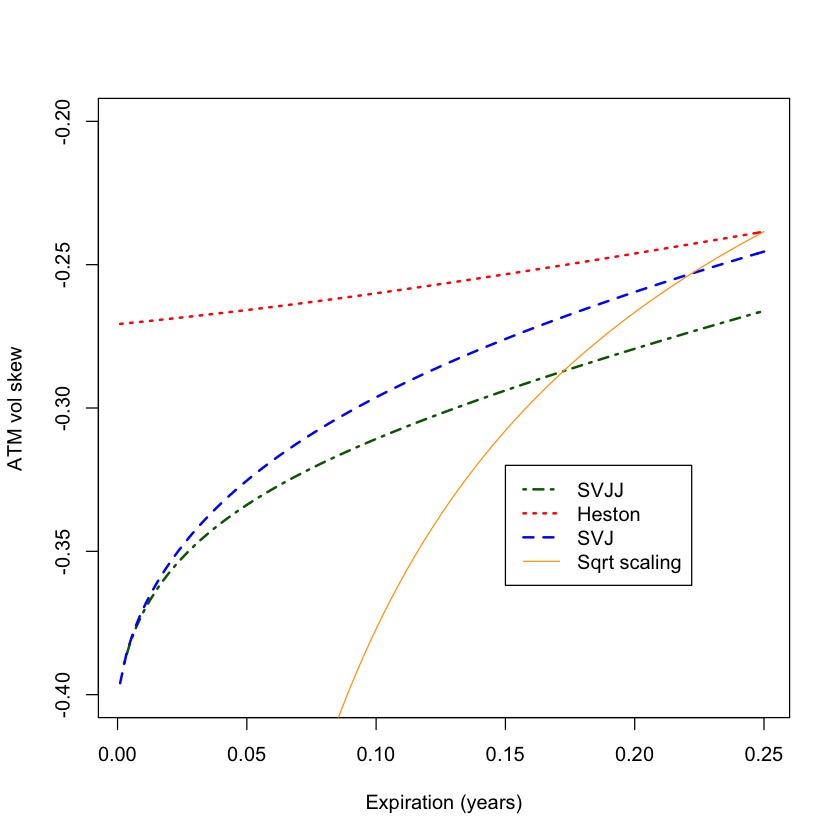

In [11]:
curve(sk(x),from=0.0025,to=.25,col="dark green",type="l",lwd=2,lty=4,ylab="ATM vol skew",xlab="Expiration (years)",ylim=c(-.4,-.2)) 
curve(atmSkewV(phiHeston(subSVJJ),x),from=.001,to=.25,col="red",lty=3,lwd=2,add=T) 
curve(atmSkewV(phiSVJ(subSVJJ),x),from=.001,to=.25,col="blue",lty=2,lwd=2,add=T) 

# Compare with sqrt(t) scaling
skew25 <- atmSkew(phiHeston(subSVJJ),.25) 
curve(skew25/sqrt(x/.25),from=.001,to=.25,col="orange",add=T)

leg.txt <- c("SVJJ","Heston", "SVJ", "Sqrt scaling") 
legend(x=.15,y=-.32,leg.txt,lty=c(4,3,2,1),col=c("dark green","red","blue","orange"),lwd=c(2,2,2,1))

<a name="fig:shortdatedskewSVJJ"></a>Figure 4: This graph is a short-expiration detailed view of the graph shown in [Figure 3](#fig:combskewSVJJ).

### Remarks on the SVJJ ATM skew

- <span> By substituting the SVJJ characteristic function [(4)](#eq:SVJJcharfn) into equation [(2)](#eq:skew) for the implied volatility
skew with the BCC parameters plus a variance jump of $\gamma_v=0.1$, we
obtain the graphs shown in Figures [3](#fig:combskewSVJJ) and
[4](#fig:shortdatedskewSVJJ).</span>

    - <span>We note that the term structure of volatility skew is in
accordance with our intuition. </span>

    - <span>In particular, adding a jump in volatility doesn’t help explain
extreme short-dated volatility skews.</span>

   - However relative to stochastic volatility and SVJ models, adding a jump in volatility does
reduce the volatility of volatility required to fit longer-dated
volatility skews even if that comes at the expense of a seemingly even
more unreasonable estimate for the average stock price jump.

### Heston and SVJ fits to 15-Sep-2005 SPX option data

|   | **Heston**  | **SVJ**     |
|:---:|---------:|--------:|
|  $v$   |  0.0174 |  0.0158 |
| $\bar v$  |  0.0354 |  0.0439 |
| $\eta$  |  0.3877 |  0.3038 |
| $\rho$  | -0.7165 | -0.6974 |
| $\lambda$ |  1.3253 |  0.5394 |
| $\lambda_J$ |         |  0.1308 |
| $\delta$  |         |  0.0967 |
| $\alpha$  |         | -0.1151 |

<a name="table:SPX3"></a>Table 2: Heston and SVJ fit to the SPX surface as of the close on 15-Sep-2005.

### Comparing model and empirical volatility surfaces

- <span> One good way to see how well the SVJ model fits the empirical
implied volatility surface overall is to compare the two volatility
surfaces graphically.</span>


- <span> We see from [Figure 5](#fig:spxsvjcompare) that in contrast to the
Heston case, the SVJ model succeeds in generating a volatility surface
that has the main features of the empirical surface although the fit is
not perfect.</span>

    - <span>Again, for longer expirations, the fit is pretty good.</span>

### 3D plots of SPX and fitted SVJ surfaces

First, here are some SVJ parameters that generate a more or less decent fit to the volatility surface as of September 15, 2005:

In [12]:
paramsSVJ050915 <- list(
    v= 0.0158,
    vbar=0.0439,
    eta=0.3038,
    rho=-0.6974,
    lambda=0.5394,
    lambdaJ = 0.1308,
    delta = 0.0967,
    alpha = -0.1151
    ) 

Once again, here are the SVI parameters corresponding to the SVI fit shown in Figures 3.2 and 3.3 of The Volatility Surface:

In [13]:
texp <- c(0.003832991, 0.098562628, 0.175336527, 0.251996350, 0.501140771, 0.750171116, 1.248574036, 1.746748802)

svidata <- c(
 c(-0.0001449630, 0.0092965440, 0.0196713280, -0.2941176470,-0.0054273230),
 c(-0.000832134	, 0.024439766 , 0.069869455 , -0.299975308 , 0.02648364  ), 
 c(-0.0008676750, 0.0282906450, 0.0873835580, -0.2892204290, 0.0592703000), 
 c(-0.0000591593, 0.0331790820, 0.0812872370, -0.3014043240, 0.0652549210),
 c(0.0011431940	, 0.0462796440, 0.1040682980, -0.3530782140, 0.0942000770), 
 c(0.0022640980	, 0.0562604150, 0.1305339330, -0.4387409470, 0.1111230690), 
 c(0.0040335530	, 0.0733707550, 0.1707947600, -0.4968970370, 0.1496609160), 
 c(0.0034526910	, 0.0917230540, 0.2236814130, -0.4942213210, 0.1854128490));

sviMatrix <- as.data.frame(t(array(svidata,dim=c(5,8))));
colnames(sviMatrix)<-c("a","b","sig","rho","m")

In [14]:
# Inspect the matrix
sviMatrix

a,b,sig,rho,m
-0.0001449630,0.009296544,0.01967133,-0.2941176,-0.005427323
-0.0008321340,0.024439766,0.06986945,-0.2999753,0.026483640
-0.0008676750,0.028290645,0.08738356,-0.2892204,0.059270300
-0.0000591593,0.033179082,0.08128724,-0.3014043,0.065254921
0.0011431940,0.046279644,0.10406830,-0.3530782,0.094200077
0.0022640980,0.056260415,0.13053393,-0.4387409,0.111123069
0.0040335530,0.073370755,0.17079476,-0.4968970,0.149660916
0.0034526910,0.091723054,0.22368141,-0.4942213,0.185412849


Now generate a 3D plot of the SVJ surface:

In [15]:
k <- seq(-.5,.5,0.01) # Vector of log-strikes
t <- seq(0.04,1.74,0.02) # Vector of times

vol1 <- function(k,t){bsvol(phiSVJ(subSVJJ),k,t)}
vol2 <- function(k,t){sapply(k,function(k){vol1(k,t)})}
volSVJ <- function(k,t){sapply(t,function(t){vol2(k,t)})}

zSVJ <- volSVJ(k,t) 
zSVJ <- (zSVJ>.1)*zSVJ+(zSVJ <=.15)*.15 

# First the analytical formula: 
z <- (zSVJ>.05)*zSVJ+(zSVJ <= 0.05)*.05 

# Add colors
nbcol <- 100 
color <- rainbow(nbcol,start=.0,end=.2,alpha=0.5) 

nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol) 

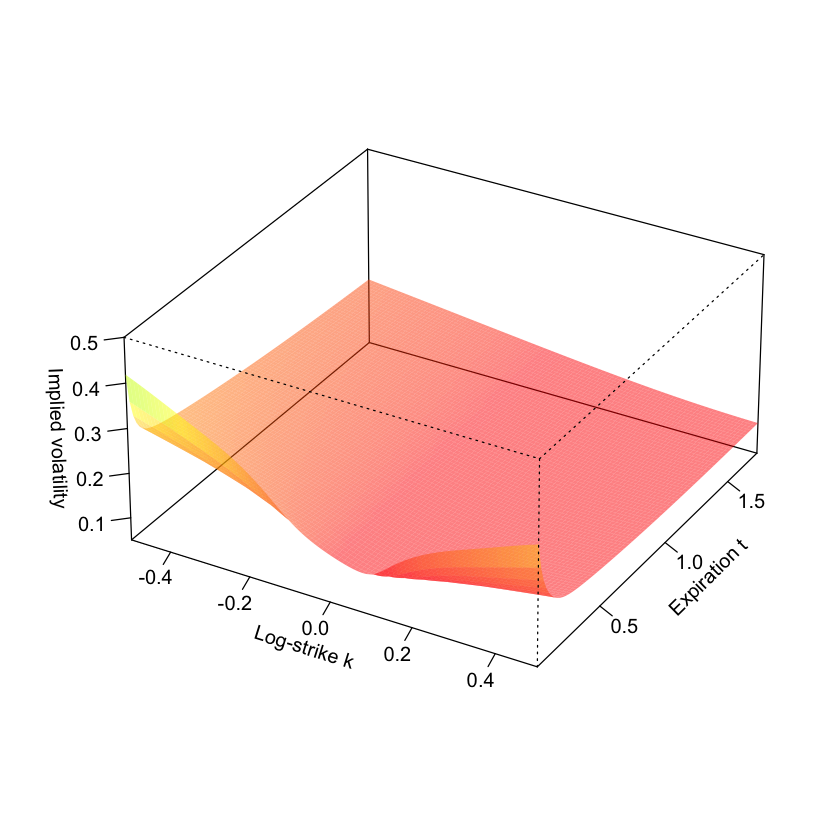

In [16]:
# Generate 3D plot of SVJ surface
persp(k, t, zSVJ-0.05, col=color[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 

Next plot the empirical surface:

In [17]:
volTVS <- function(k,t){sqrt(sviW(sviMatrix,texp,k,t)/t)}

z2 <- t(volTVS(k,t))  # Array of empirical volatilities

# Add colors
nbcol <- 100 
color2 <- rainbow(nbcol,start=.4,end=.6,alpha=0.5) 
nrz <- nrow(z2)
ncz <- ncol(z2)
# Compute the z-value at the facet centres
zfacet <- z2[-1, -1] + z2[-1, -ncz] + z2[-nrz, -1] + z2[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol) 

Warning message:
In persp.default(k, t, z2, col = color2[facetcol], phi = 30, theta = 30, : surface extends beyond the box

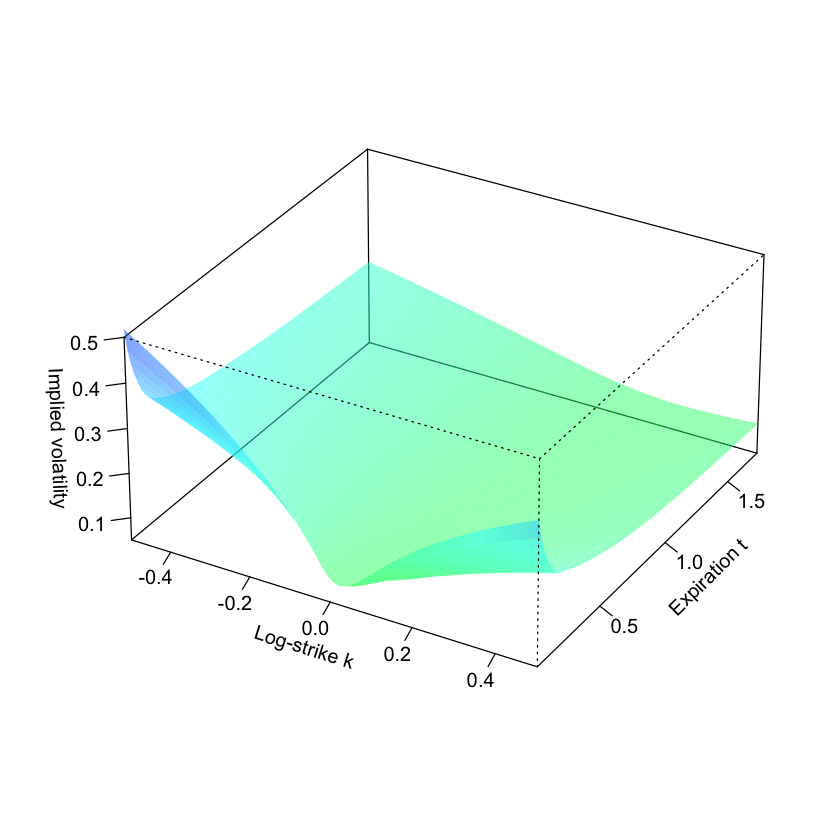

In [18]:
# Generate 3D plot
persp(k, t, z2, col=color2[facetcol], phi=30, theta=30, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 

A function to superimpose the two surfaces and easily change perspective:

In [19]:
view <- function(phi,theta){

# Generate 3D plot of analytical solution
persp(k, t, zSVJ-0.05, col=color[facetcol], phi=phi, theta=theta, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=70,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 
    
par(new=T)  # To superimpose

persp(k, t, z2, col=color2[facetcol], phi=phi, theta=theta, 
    r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=70,ticktype="detailed",
    shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",zlim=c(.05,.5)) 
}

Warning message:
In persp.default(k, t, z2, col = color2[facetcol], phi = phi, theta = theta, : surface extends beyond the box

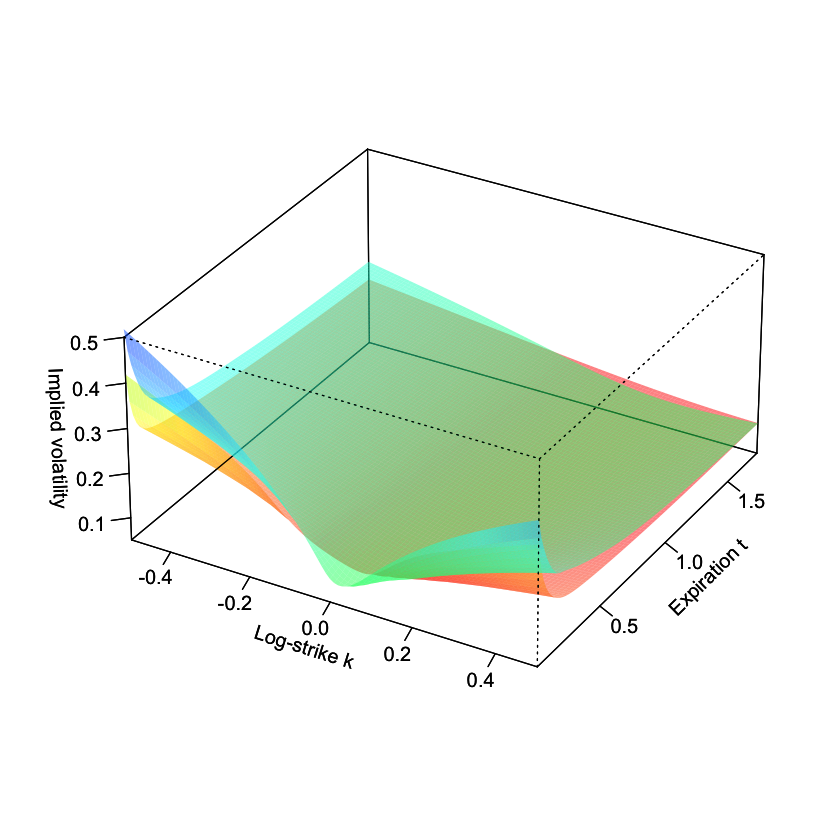

In [20]:
view(30,30)

<a name="fig:spxsvjcompare"></a>Figure 5: Comparison of the empirical SPX implied volatility surface with the
SVJ fit as of September 15, 2005. In contrast to the Heston case, the
major features of the empirical surface are replicated by the SVJ model.
The upper surface is the empirical SPX volatility surface and the
reddish lower one the SVJ fit. The SVJ fit surface has been shifted down
by 5 volatility points for ease of visual
comparison.

Warning message:
In persp.default(k, t, z2, col = color2[facetcol], phi = phi, theta = theta, : surface extends beyond the box

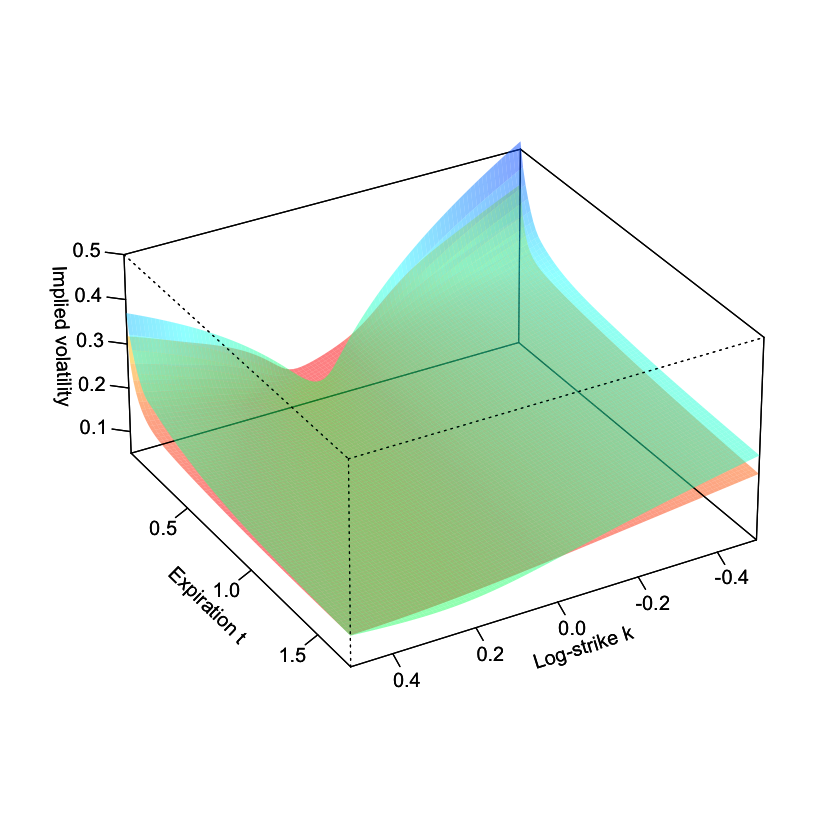

In [21]:
view(30,150)

Warning message:
In persp.default(k, t, z2, col = color2[facetcol], phi = phi, theta = theta, : surface extends beyond the box

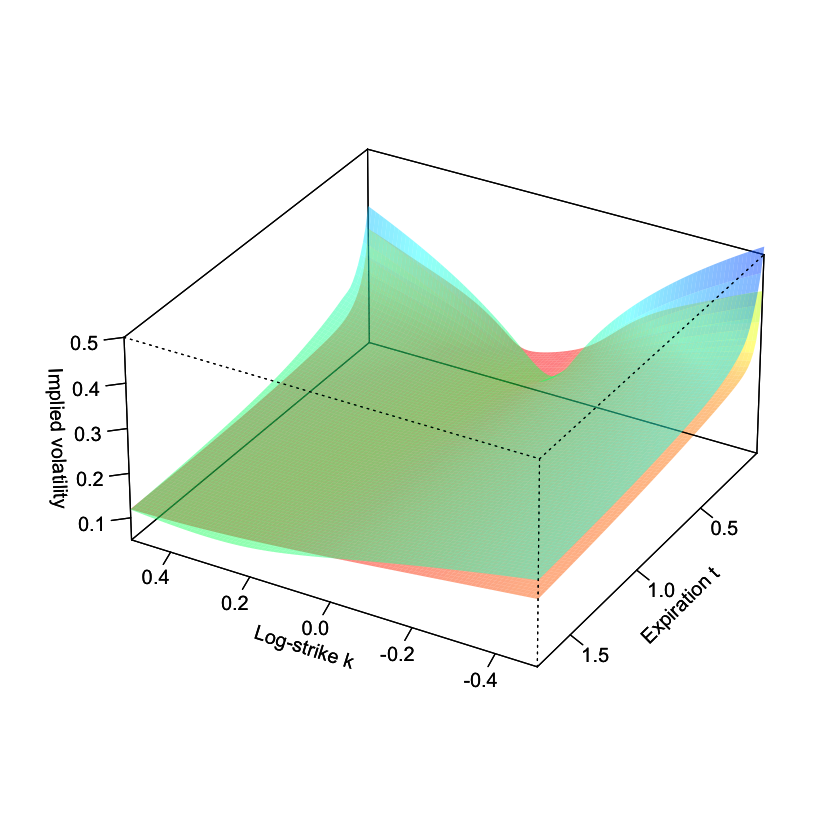

In [22]:
view(30,210)

Warning message:
In persp.default(k, t, z2, col = color2[facetcol], phi = phi, theta = theta, : surface extends beyond the box

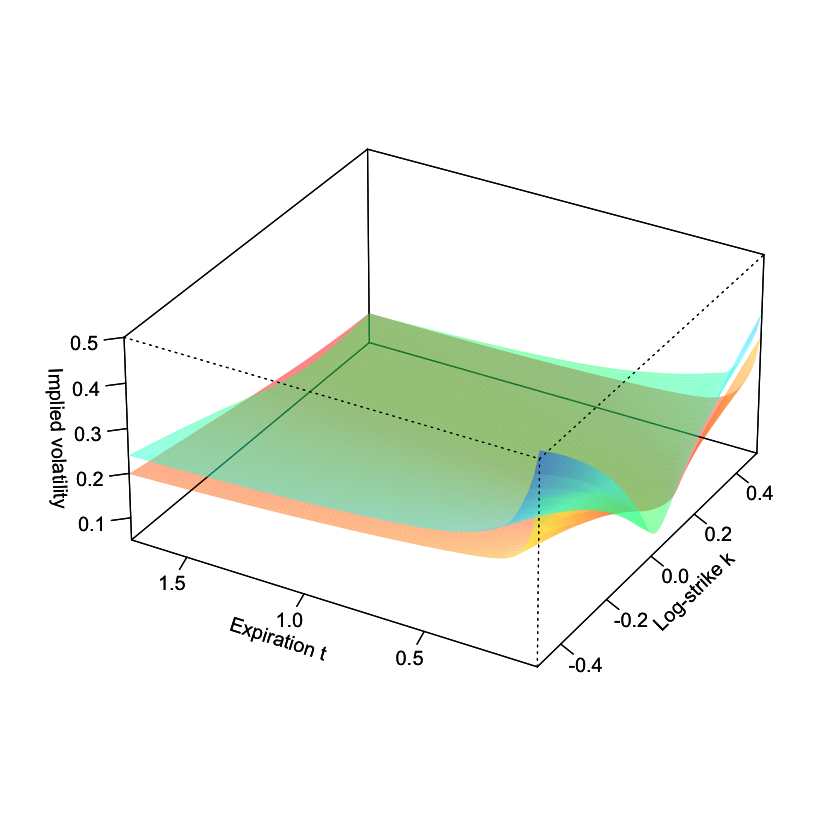

In [23]:
view(30,300)

### Why the SVJ model wins

- <span> SVJ fits the observed implied volatility surface reasonably well
in contrast to the Heston model.</span>


- <span>You might think that making dynamics more reasonable by including
jumps in volatility as in the SVJJ model might generate surfaces that
fit even better.</span>

    - <span> Sadly, we can see from Figures [3](#fig:combskewSVJJ) and
[4](#fig:shortdatedskewSVJJ) that not only does the SVJJ model have more
parameters than the SVJ model, but it’s harder to fit to observed option
prices.</span>


- <span> The SVJ model thus emerges as a clear winner in the comparison
between Heston, SVJ and SVJJ models.</span>

### Stochastic time-changed Lévy processes 

-   <span>So far we have focussed on diffusion models or diffusion
    models with jumps.</span>

-   <span>There has been much academic interest in modeling underlyings
    using Lévy processes.</span>

-   <span>In the rest of this lecture, we will work through a paper by
    Wim Schoutens and collaborators, that calibrates a number of
    different models to the EuroStoxx volatility surface.</span>

    -   <span>The numerical results presented seem to directly
        contradict claims made in The Volatility Surface concerning the
        model-dependence of the value of certain exotic options.</span>

    -   <span>Who is right?</span>

-   <span>In the process of finding the answer, we will learn about
    stochastic time changes and the simulation of Lévy processes.</span>

### Intuition for down-and-out options

-   <span>Suppose we sell a knock-out call option with barrier $B$ equal
    to the strike price $K$ below the current stock price $S_0$.</span>

-   <span>Suppose further that we hedge this position by buying one
    stock per option and we charge $S_0-K$ as the premium.</span>

-   <span>With zero rates and dividends, this hedge is perfect.</span>

-   <span> In this special case, a knock-out option has no optionality
    whatsoever. Delta is one, gamma is zero and vega is zero.</span>

### Similarity to stop-loss orders

-   <span>So long as the stock price remains above the barrier level, we
    are net flat.</span>

-   <span>When the barrier is hit, the option knocks out and we are left
    long of the stock.</span>

-   <span>This is exactly the portfolio we would have if the option
    buyer had left us a stop-loss order to sell stock if the price ever
    reached the barrier level $B$ – with one big difference:</span>

    -   <span> A barrier option like this guarantees execution at the
        barrier level but a conventional stop-loss order would get
        filled at the earliest opportunity after the barrier is hit
        (usually a bit below the barrier).</span>

    -   <span>If we could really trade continuously, there would be no
        difference between the two contracts.</span>

-   <span> In the real world, knock-out options are priced more highly
    than the diffusion model price to compensate for the risk of the
    stock price gapping through the barrier level.</span>

### Hand-waving extension

-   <span>If the strike price $K$ and the barrier level $B$ are not
    equal but not so far apart with $B \leq K \leq S_0$, it is natural
    to expect that neither gamma nor vega would be very high relative to
    the European option with the same strike $K$.</span>

-   <span> Nor would we expect the price of such a knock-out option to
    be very sensitive to the model used to value it (assuming of course
    that this model is calibrated to vanilla options). </span>

### Overview of the Schoutens et al. paper (SST)

The authors calibrate the following seven models to the EuroStoxx
volatility surface as of October 7th, 2003:

-   <span>HEST : The Heston model</span>

-   <span>HESJ : The Heston model with jumps</span>

-   <span>BNS : The Barndorff-Nielsen Shephard model</span>

-   <span>VGCIR : The Variance Gamma model with CIR time change</span>

-   <span>VGOU : The Variance Gamma model with OU-Gamma time
    change</span>

-   <span>NIGCIR : The Normal Inverse Gaussian model with CIR time
    change</span>

-   <span>NIGOU : The Normal Inverse Gaussian model with OU time
    change</span>

### The Schoutens barrier option challenge

-   <span>The authors then price various exotic options using the
    different models, finding that results vary wildly between models
    *even though all the models are calibrated to the same European
    options*. </span>

-   <span> In particular, the first row of Table 5 of the SST paper has
    the following prices for 3-year down-and-out barrier options struck
    at-the-money with a 95% barrier:</span>

  -------- -------- -------- -------- -------- -------- -------- --------
              NIGOU    VGCIR     VGOU     HEST     HESJ      BNS   NIGCIR
      Euro   509.76   511.80   509.33   509.39   510.89   509.89   512.21
    B=0.95   300.25   293.28   318.35   173.03   174.64   230.25   284.10
  -------- -------- -------- -------- -------- -------- -------- --------

-   <span> For comparison, with $S_0=2461.44$ as of 07-Oct-2003, the
    difference $S_0-B$ is $0.05\,S_0=123.07$</span>

-   <span>Only the HEST and HESJ are close to being consistent with the
    intuition we developed earlier!</span>

-   <span>The VGOU price is more than double our rough estimate!</span>

### Intuition for lookback options

-   <span>Consider a portfolio long a lookback call (paying the
    $(S_{max}-K)^+$ struck at $K$ and short two European call options struck
    at $K$. </span>

-   <span>If the stock price never reaches $K$, both the lookback and
    the European option expire worthless.</span>

-   <span>If and when the stock price does reach K and increases by some
    small increment $\Delta K$, the value of the lookback option must
    increase by $\Delta K$ (since $K+\Delta K$ is now the new
    maximum).</span>

-   <span>We must rebalance our hedge portfolio by selling two calls
    struck at $K$ and buying two calls struck at $K+\Delta K$. The
    profit generated by rebalancing is just $\Delta K$.</span>

-   <span>We conclude that we have a replicating hedge and so the fair
    value of a lookback call (with zero rates and dividends) is twice
    the fair value of the corresponding European call. </span>

### The Schoutens lookback option challenge

-   <span> A similar argument shows that a lookback option that pays the
    final stock price minus the minimum should be priced as a European
    straddle.</span>

-   <span> Table 3 of the SST paper has the following prices for ATM
    lookback options:</span>

<!--
A different style of table for your choice:

|          | NIGOU  | VGCIR  | VGOU   | HEST   | HESJ   | BNS    | NIGCIR |
|---------:|--------|--------|--------|--------|--------|--------|--------|
|     Euro | 509.76 | 511.80 | 509.33 | 509.39 | 510.89 | 509.89 | 512.21 |
| Lookback | 722.34 | 724.80 | 713.49 | 838.48 | 845.18 | 771.28 | 730.84 |
-->


  ---------- -------- -------- -------- -------- -------- -------- --------
                NIGOU    VGCIR     VGOU     HEST     HESJ      BNS   NIGCIR
        Euro   509.76   511.80   509.33   509.39   510.89   509.89   512.21
    Lookback   722.34   724.80   713.49   838.48   845.18   771.28   730.84
  ---------- -------- -------- -------- -------- -------- -------- --------

-   <span>We note that HEST and HESJ are the models that return values
    closest to our rough guess of $1,000$.</span>

### Checking the computations

-   <span>Our first assumption might be that the authors’ computations
    were wrong.</span>

-   <span>To check their computations, we need to simulate the various
    models.</span>

    -   <span> We don’t know what interest rate or dividend assumptions
        the authors used so for simplicity, we take them to be
        zero.</span>

-   <span>We get to exercise our facility in generating option prices
    from characteristic functions.</span>

### The Heston characteristic function

Recall the Heston process

\begin{eqnarray*}
dS_t &=& \sqrt {v_t} \,S_t\, dZ_t \nonumber\\
dv_t &=&  - \lambda \,(v_t - \bar v)\,dt + \eta \,\sqrt {v_t}\,
dW_t
\end{eqnarray*}

with $\left\langle {dZ_t \,{dW_t} } \right\rangle = \rho \,{ dt}$. 

The
Heston characteristic function is:

$$\phi_{HEST}(u)=\exp \left\{ C (u,t )\,\bar v + D (u,t)\,v\right \}$$

with $C(u,t)$ and $D(u,t)$ the usual complicated functions of the model
parameters.

### The HESJ characteristic function

The Heston model with jumps process is:

\begin{eqnarray*}
\frac{dS_t}{S_t} &=& -\mu_J\,dt+\sqrt {v_t} \, dZ_t +J_t\,dN_t\nonumber\\
dv_t &=&  - \lambda\, (v_t - \bar v)\,dt + \eta \,\sqrt {v_t}\,
dW_t
\end{eqnarray*}

where $N_t$ is a Poisson process with rate $\lambda_J$ and the jumps
$J_t$ are lognormally distributed with mean $\alpha$ and standard
deviation $\delta$. As before
$\left\langle {dZ_t \,{dW_t} } \right\rangle = \rho \,{ dt}$.

The HESJ characteristic function is:

$$\phi_{HESJ}(u)=\phi_{HEST}(u)\,\phi_{JUMP}(u)$$ with
$$
\begin{eqnarray*}
&&\phi_{JUMP}(u)\\&=&\exp\left\{-i\,u\,\lambda_J\,t\,\left( e^{\alpha + \delta^2/2} - 1 \right) + \lambda_J\,t\,\left(e^{i\,u\,\alpha - u^2/2\,\delta^2} - 1\right)\right\}.
\end{eqnarray*}
$$

### The BNS process

The version of the Barndorff-Nielsen-Shephard model that is implemented
in SST has the following dynamics:

\begin{eqnarray*}
d\log S_t &=& -\left[\lambda\,k(-\rho)+v_t/2\right]\,dt+\sqrt{v_t}\,dW_t+\rho\,dz_{\lambda\,t}\nonumber\\
dv_t &=&  - \lambda v_t\,dt + dz_{\lambda\,t}
\end{eqnarray*}

Here $z_t$ is the compound Poisson process $$z_t=\sum_{i=1}^N\,x_i$$
where $N$ is a Poisson process with rate $a$ and each $x_i$ follows an
exponential law with rate $b$.

If the process for $v$ is started with an initial value from its
stationary Gamma distribution, we obtain

$$k(u):= \mathbb{E}\left[e^{-u\,z_1}\right]=-\frac{a\,u}{b+u}$$ 

as the
cumulant function of $z_1$.

### The BNS characteristic function

The BNS characteristic function is given by

\begin{eqnarray*}
\phi_{BNS}(u)&=&\exp\left\{-i\,u\,\frac{a\,\lambda\,\rho}{b - \rho}\,t\right\}\,
    \exp\left\{-\frac{1 - e^{-\lambda\,t}}{\lambda}\,(u^2 + i\,u)\,v_0/2\right\}\\
    &&\times\exp\left\{\frac{a}{b-f_2(u)}\, \left[b\,\log\left(\frac{b-f_1(u)}{b-i\,u\,\rho}\right) + f_2(u)\,\lambda\,t\right]\right\}
\end{eqnarray*}

with

\begin{eqnarray*}
f_1(u)&=&i\,u\,\rho-\frac{1-e^{-\lambda\,t}}{2\,\lambda}\,(u^2+i\,u)\\
f_2(u)&=&i\,u\,\rho-\frac{1}{2\,\lambda}\,(u^2+i\,u)
\end{eqnarray*}

### The AVG characteristic function

-   <span>The Asymmetric Variance Gamma characteristic function is given
    by
    
    $$\phi_{AVG}(u)=\left(\frac{G\,M}{G\,M+(M-G)\,i\,u+u^2}\right)^C$$
    with $C>0,\,G>0,\,M>0$.</span>


-   <span> $G$ and $M$ are parameters controlling the size of up and
    down jumps respectively. If $M>G$, the density will be
    left-skewed.</span>


-   <span> $C$ controls the rate of jump arrivals.</span>

### The NIG characteristic function

-   <span>The Normal Inverse Gaussian characteristic function is given
    by
    $$\phi_{NIG}(u)=\exp\left\{-\delta\,\left(\sqrt{\alpha^2-(\beta+i\,u)^2}-\sqrt{\alpha^2-\beta^2}\right)\right\}$$
    with $\alpha>0,\,\beta^2<\alpha^2,\,\delta>0$.</span>


-   <span> $\alpha$ controls the sizes of jumps and $\beta$ is an
    asymmetry parameter.</span>


-   <span> $\delta$ controls the rate of jump arrivals.</span>

### Stochastic time change

-   <span> One way to model stochastic volatility is by making time
    stochastic. The idea is that parameters are constant in business
    time but vary in calendar (or wall clock) time.</span>


-   <span>For example, the Heston model can be viewed as Brownian Motion
    with a CIR (square-root process) time change.</span>

-   <span>Obviously, stochastic time has to be monotonically increasing
    with respect to calendar time so the process modeling the time
    change has to be positive. </span>


-   <span>For a given positive time-change process $y_t$, the business
    time elapsed in $t$ units of calendar time is given by
   
   $$\tau_t=\int_0^t\,y_s\,ds.$$ </span>

### Characteristic function of a time-changed Lévy process

Consider the time-changed process $Y_t=X_{\tau_t}$ with $X$ a Lévy
process, and $X$ and $\tau$ independent. The characteristic function of
$Y_t$ may be computed as follows:

<a name="eq:timeChange"></a>(5)
\begin{eqnarray*}
\phi_{Y_t}(u)&=&\mathbb{E}\left[e^{i\,u\,Y_t}\right]\nonumber\\
&=&\mathbb{E}\left[e^{i\,u\,X_{\tau_t}}\right]\nonumber\\
&=&\mathbb{E}\left[\mathbb{E}\left[\left.e^{i\,u\,X_\theta}\right|\theta=\tau_t\right]\right]\nonumber\\
&=&\mathbb{E}\left[e^{\psi_X(u)\,\tau_t}\right]\nonumber\\
&=&\phi_{\tau_t}\left(-i\,\psi_X(u)\right)
\end{eqnarray*}

where $\psi_X(u):=\log{\mathbb{E}\left[e^{i\,u\,X_1}\right]}$ is the
characteristic exponent of $X$.

### Special case: Hull and White

Hull and White consider the process 
\begin{eqnarray*}
\frac {dS_t} {S_t}&=&\phi\,dt+\sigma_t\,dZ_t\\
\frac{dv_t}{v_t}&=&\mu\,dt+\xi\,dW_t
\end{eqnarray*}


with $v_t=\sigma_t^2$ and ${\mathbb{E} }[dW_t\,dZ_t]=0$.

The option price in this model is given by

<a name="eq:HW"></a>(6)
$$
C(k,v,T)=\int\,C_{BS}(k,w_T)\,p(w_T)\,dw_T
$$


where as usual $w_T=\int_0^T\,v_t\,dt$.

- Remark that $w_T=\int_0^T\,v_t\,dt$ is a stochastic time-change.


- The value of the option is obtained by integrating the Black-Scholes
formula over all possible values of the total variance $w_T$.

- Formula [(6)](#eq:HW) may be rewritten as 
\begin{eqnarray*}
C(k,v,T)&=&\mathbb{E}_{w_T}\left[C_{BS}(k,w)\right]\\
&=&\mathbb{E}_{w_T}\left[\mathbb{E}_{S_w}\left[(S_w-K)^+\right]\right]
\end{eqnarray*}

- It’s very important to note that this only works if the stock process
$dW$ and the volatility process $dZ$ are independent.

    - Otherwise, it’s more complicated with the result depending on the
details of the assumed stock and volatility processes.

### The CIR stochastic clock

In this case, the time change $y_t$ satisfies

$$dy_t=-\kappa(\eta-y_t)\,dt+\lambda\,\sqrt{y_t}\,dZ_t.$$ 

The
characteristic function of the time change $\tau_t=\int_0^t\,y_s\,ds$ is
given by the well-known CIR formula:


$$\phi_{CIR}(u)= \frac{e^{\kappa^2\,\eta\,t/\lambda^2}\,\exp\left\{\frac{2\,y_0\,i\,u}{\kappa+\gamma/\tanh(\gamma\,t/2)}\right\}}
{\left(\cosh(\frac{\gamma\,t}{2}) + \frac{\kappa}{\gamma}\,\sinh\left(\frac{\gamma\,t}{2}\right)\right)^{2\,\kappa\,\eta/\lambda^2}}$$
where $$\gamma=\sqrt{\kappa^2-2\,\lambda^2\,i\,u}$$

### The OU-$\Gamma$ stochastic clock

The time change $y_t$ satisfies
$$dy_t=-\lambda\,y_t\,dt+\,dz_{\lambda\,t}$$ where the process $z_t$ is
the compound Poisson process $$z_t=\sum_{i=1}^N\,x_i$$ where $N$ is a
Poisson process with rate $a$ and each $x_i$ follows an exponential law
with rate $b$.

The characteristic function of the time change
$\tau_t=\int_0^t\,y_s\,ds$ is then given by:

\begin{eqnarray*}
\phi_{OU}(u)&=& \exp\left\{
i\,u\,y_0\,\frac{1-e^{-\lambda\,t}}{\lambda}\right.\\
&&+\left.\frac{\lambda\,a}{i\,u - \lambda\,b}\,\left[
b\,\log\left(\frac{b}{b - i\,u\,(1 - e^{-\lambda\,t})/\lambda}\right)-i\,u\,t\right]
\right\}.
\end{eqnarray*}

### Computing option prices from the characteristic function

-   <span>Now that we can compute all the desired characteristic
    functions in closed form, we can compute European option
    prices.</span>


-   <span> Recall equation (5.6) of *The Volatility Surface*:
    $$C(S,K,T)=S-\sqrt{SK}\frac{1}{\pi}\int_0^\infty\frac{du}{u^2+\frac{1}{4}}
    \,\mathrm{Re}\left[e^{-iuk}\phi_T\left(u-i/2\right)\right]$$ with
    $k:=\log\left({K}/{S}\right)$. </span>

### Checking SST numerics

-   <span>We don’t know from the SST paper what dividend and interest
    rate assumptions were used to calibrate the models and generate
    option prices.</span>


-   <span>All we need to do is to ensure that with zero rates and
    dividends, all of the models generate the same European option
    prices</span>

-   <span>Equivalently, we can check that these models return:</span>

    -   <span>the same densities.</span>

    -   <span>the same implied volatility smiles.</span>


-   <span>We choose to compare implied volatility smiles (SST choose to compare option values but these are almost
    indistinguishable between models).

### Comparison of volatility smiles: 1 year

First we code BNS, Heston, and SVJ characteristic functions with SST parameters:

In [24]:
subBNS <- list(lambda =.5474,a = .6069,b = 18.6075,rho = -4.675,v0 = 0.0433) 

# The Barndorf-Nielsen-Shephard model (BNS)
phiBNS <- function(params){

    lambda <- params$lambda 
    a <- params$a 
    b <- params$b 
    rho <- params$rho 
    v0 <- params$v0 
    
    function(u,t){
    f1 <- 1i*u*rho - (1-exp(-lambda*t))/(2*lambda)*(u^2+1i*u) 
    f2 <- 1i*u*rho - (u^2+1i*u)/(2*lambda) 
    term1 <- exp(-1i*u*(a*lambda*rho)/(b - rho)*t) 
    term2 <- exp(-(1 - exp(-lambda*t))/(2*lambda)*(u^2 + 1i*u)*v0) 
    term3 <- exp(a/(b-f2)* (b*log((b-f1)/(b-1i*u*rho)) + f2*lambda*t)) 
    return(term1*term2*term3) 
    }
}

In [25]:
subHeston <- list(lambda = 0.6067,rho = -0.7571,eta = 0.2928,vbar = 0.0707,v = .0654) 

# The Heston model
phiHeston <- function(params){
    
    lambda <- params$lambda 
    rho <- params$rho 
    eta <- params$eta 
    vbar <- params$vbar 
    v <- params$v 
    
    function(u, t){

    al <- -u*u/2 - 1i*u/2 
    bet <- lambda - rho*eta*1i*u 
    gam <- eta^2/2 
    d <- sqrt(bet*bet - 4*al*gam) 
    rp <- (bet + d)/(2*gam) 
    rm <- (bet - d)/(2*gam) 
    g <- rm / rp 
    D <- rm * (1 - exp(-d*t))/ (1 - g*exp(-d*t)) 
    C <- lambda * (rm * t - 2/eta^2 * log( (1 - g*exp(-(d*t)))/(1 - g) ) ) 
    return(exp(C*vbar + D*v)) 
    }
}

In [26]:
subSVJ = list(lambda = 0.4963,rho = -.99,eta = .2286,vbar = 0.065,v = 0.0576,lambdaJ = .1382,alpha = -.1791,delta = .1346) 

# phiJump
phiJump <- function(params){

    lambdaJ <- params$lambdaJ  
    alpha <- params$alpha 
    delta <- params$delta 

    function(u,t){  
    tmp <- exp(-1i*u*lambdaJ*(exp(alpha + delta^2/2) - 1)*t + 
    lambdaJ*t*(exp(1i*u*alpha - u^2/2*delta^2) - 1)) 
    return(tmp) 
    }         
}

In [27]:
subSVJ = list(lambda = 0.4963,rho = -.99,eta = .2286,vbar = 0.065,v = 0.0576,lambdaJ = .1382,alpha = -.1791,delta = .1346) 

# phiJump
phiJump <- function(params){

    lambdaJ <- params$lambdaJ  
    alpha <- params$alpha 
    delta <- params$delta 

    function(u,t){  
    tmp <- exp(-1i*u*lambdaJ*(exp(alpha + delta^2/2) - 1)*t + 
    lambdaJ*t*(exp(1i*u*alpha - u^2/2*delta^2) - 1)) 
    return(tmp) 
    }         
}

# The HESJ or SVJ model
phiSVJ <- function(params){
    function(u, t){  
    return(phiHeston(params)(u,t)*phiJump(params)(u,t)) 
    }
}

Next we code the CIR and OU stochastic clocks:

In [28]:
# CIR
phiCIR <- function(params){

    kappa <- params$kappa 
    eta <- params$eta 
    y0 <- params$y0 
    lambda <- params$lambda
        
    function(u,t){
    gamma <- sqrt(kappa^2 - 2*lambda^2*1i*u)  
    numer <- exp(kappa^2*eta*t/lambda^2)*exp(2*y0*1i*u/(kappa+gamma/tanh(gamma*t/2))) 
    denom <- (cosh(gamma*t/2) + kappa/gamma*sinh(gamma*t/2))^(2*kappa*eta/lambda^2) 
    return(numer/denom) 
    }
}

In [29]:
# OU
phiOU <- function(params){

    y0 <- params$y0 
    lambda <- params$lambda
    a <- params$a 
    b <- params$b 
    
    function(u,t){
    tmp1 <- 1i*u*y0*(1 - exp(-lambda*t))/lambda 
    tmp2 <- lambda*a/(1i*u - lambda*b) 
    tmp3 <- b*log(b/(b - 1i*u*(1 - exp(-lambda*t))/lambda))-1i*u*t 
    
    return(exp(tmp1+tmp2*tmp3)) 
    }
}

Now use equation [(5)](#eq:timeChange) to get time-changed Normal Inverse Gaussian (NIG) with CIR and OU subordination:

#### Normal Inverse Gaussian (NIG)

In [30]:
psiNIG <- function(params){

    alpha <- params$alpha 
    beta <- params$beta 
    delta <- params$delta 
    
    function(u){ 
    return(-(sqrt(alpha^2 - (beta + 1i*u)^2) - 
    sqrt(alpha^2 - beta^2))*delta) 
    }
}

#### The Normal Inverse Gaussian (NIG) model with CIR subordination

In [31]:
subNIGCIR <- list(alpha = 16.1975,beta = -3.1804,delta = 1.0867,
                kappa = 1.2101, eta = 0.5507, lambda = 1.7864, y0 = 1) 

phiNIGCIR <- function(params){

    function(u, t){  
    numer <- phiCIR(params)(-1i*psiNIG(params)(u),t) 
    denom <- phiCIR(params)(-1i*psiNIG(params)(-1i),t)^(1i*u) 
    return(numer/denom) 
    }
}

#### The Normal Inverse Gaussian (NIG) model with OU subordination

In [32]:
subNIGOU <-list( alpha = 8.8914, beta = -3.1634, delta = 0.6728, lambda = 1.7478, a = 0.3442, b = 0.7628, y0 = 1) 

phiNIGOU <- function(params){

    function(u, t){  
    numer <- phiOU(params)(-1i*psiNIG(params)(u),t) 
    denom <- phiOU(params)(-1i*psiNIG(params)(-1i),t)^(1i*u) 
    return(numer/denom) 
    }
}

And repeat this for the Asymmetric Variance Gamma (AVG) model:

#### Asymmetric Variance Gamma (AVG)

In [33]:
psiAVG <- function(params){

    c <- params$c 
    g <- params$g 
    m <- params$m 
    
    function(u){ 
    return(c*log((g*m/(g*m + (m - g)*1i*u + u^2)))) 
    }
}

#### The AVG model with CIR subordination

In [34]:
subAVGCIR <- list(c = 18.0968, g = 20.0276, m = 26.3971, kappa= 1.2145, 
eta = 0.5501, lambda =  1.7913, y0 = 1) 

phiAVGCIR <- function(params){

    function(u, t){  
    numer <- phiCIR(params)(-1i*psiAVG(params)(u),t) 
    denom <- phiCIR(params)(-1i*psiAVG(params)(-1i),t)^(1i*u) 
    return(numer/denom) 
    }
}

#### The AVG model with OU subordination

In [35]:
subAVGOU <- list( c = 6.1610, g = 9.6443, m = 16.026, lambda = 1.679,
    a = 0.3484, b = 0.7664, y0 = 1) 

phiAVGOU <- function(params){

    function(u, t){  
    numer <- phiOU(params)(-1i*psiAVG(params)(u),t) 
    denom <- phiOU(params)(-1i*psiAVG(params)(-1i),t)^(1i*u) 
    return(numer/denom) 
    }
}

Now we can compare the smiles generated by all of these models:

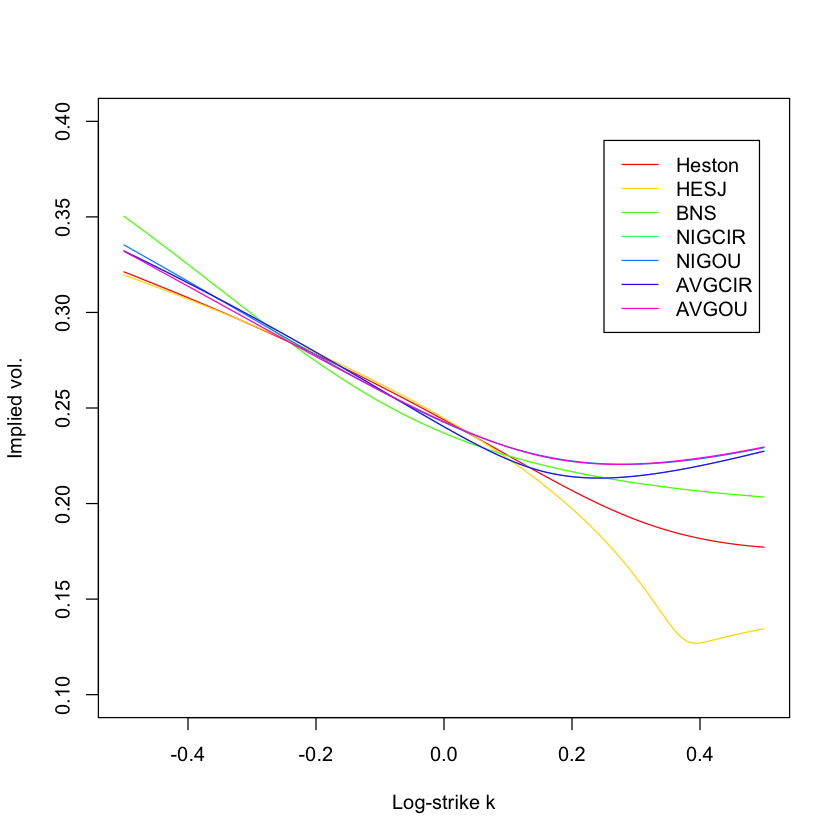

In [36]:
leg.txt <- c("Heston", "HESJ", "BNS", "NIGCIR", "NIGOU", "AVGCIR", "AVGOU") 

# First compare with 1 year expiration
clr <- rainbow(7) 
xrange <- c(-.5,.5);  yrange <- c(.1,.4) 
plot(NA,xlim=xrange,ylim=yrange,ylab="Implied vol.",xlab="Log-strike k") 

vol <- function(k){sapply(k,function(x){bsvol(phiHeston(subHeston),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[1],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiSVJ(subSVJ),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[2],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiBNS(subBNS),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[3],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiNIGCIR(subNIGCIR),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[4],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiNIGOU(subNIGOU),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[5],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiAVGCIR(subAVGCIR),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[6],add=T)

vol <- function(k){sapply(k,function(x){bsvol(phiAVGOU(subAVGOU),x,1)})}
curve(vol(x),from=-.5,to=.5,col=clr[7],add=T)

legend(x=.25,y=.39,leg.txt,lty=1,col=clr)


<a name="fig:volSmile1"></a>Figure 6: One year volatility smiles generated by various models with SST parameters.

### Comparison of volatility smiles: All expiries

Repeating this exercise for all expiries gives the following plot:

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/11/9875-11Figure7.png", align="left" width=800></h3>


<a name="fig:volSmile6"></a>Figure 7: All volatility smiles for the same models as in Figure 6.

### Interim conclusion

-   <span>We conclude that the SST numerics are correct. </span>

-   <span>All models generate more or less the same implied volatilities
    except for very short expirations.</span>

### The guaranteed stop loss contract

-   <span>Consider a hypothetical contract that pays the difference
    between a pre-agreed level (the barrier $B$) and the first stock
    price reached after the barrier is breached. </span>

    -   <span>If price paths are continuous, the fair value of this contract
    is zero.</span>

    -   <span>The fair value of this contract is sensitive only to the
    magnitude and frequency of jumps.</span>

-   <span>For indices at least, informal canvassing of traders suggests
    that this contract is worth very little.</span>



-   <span>We can approximate the value of this contract in the various
    models by simulation.</span>

    -   <span>As an example, we value this option under NIGOU.</span>

### Path generation for time-changed Lévy processes

1.  <span>Simulate the time change $y_t$ and compute the new clock
    $\tau_t$.</span>

2.  <span>Simulate the Lévy process
    $X=\{X_t,\,0 \leq t\leq \tau_T\}$.</span>

3.  <span>Compute $Y_t=X(\tau_t)$.</span>

4.  <span>Compute stock prices $S_t$ as
    $$S_t=S_0\,\frac{\exp\{X(\tau_t)\}}{\mathbb{E}[\exp\{X(\tau_t)\}]}$$
    </span>

### Simulating the OU-$\Gamma$ time-change

$$y_i=e^{-\lambda \,\Delta t}\,y_{i-1}+\sum_{k=N_{i-1}+1}^{N_i}\,x_k\,e^{-\lambda \,\Delta t\,u_k}$$
with $u_k \sim U(0,1)$ and $x_k$ exponentially distributed with rate
$b$.

$N_i$ is the Poisson random variable giving the number of jumps up to
time $t_i$.

### Simulating the OU-$\Gamma$ time-change: R-code

In [37]:
simOU <- function(T,nTimes,params){
    
    dt <- T/nTimes 
    vOut <- rep(1,nTimes)  #v0=1
    a <- params$a;  b <- params$b;  lambda <- params$lambda 
    elt <- exp(-lambda*dt) 
    
    #Generate Poisson path
    nJumps <- rpois(nTimes,lambda=a*lambda*dt) 
    
    for (i in 1:(nTimes-1))
    {
    xx <- 0 
    if (nJumps[i] >0){
    for (k in 1:nJumps[i]){
        u <- runif(1) 
        x <- rexp(1,rate=b)*elt^u 
        xx <- xx+x 
    }}
    vOut[i+1] <- vOut[i]*elt + xx     
  }
  return(c(0,cumsum(vOut)*dt)) 
}

### A typical simulated OU-$\Gamma$ time-change

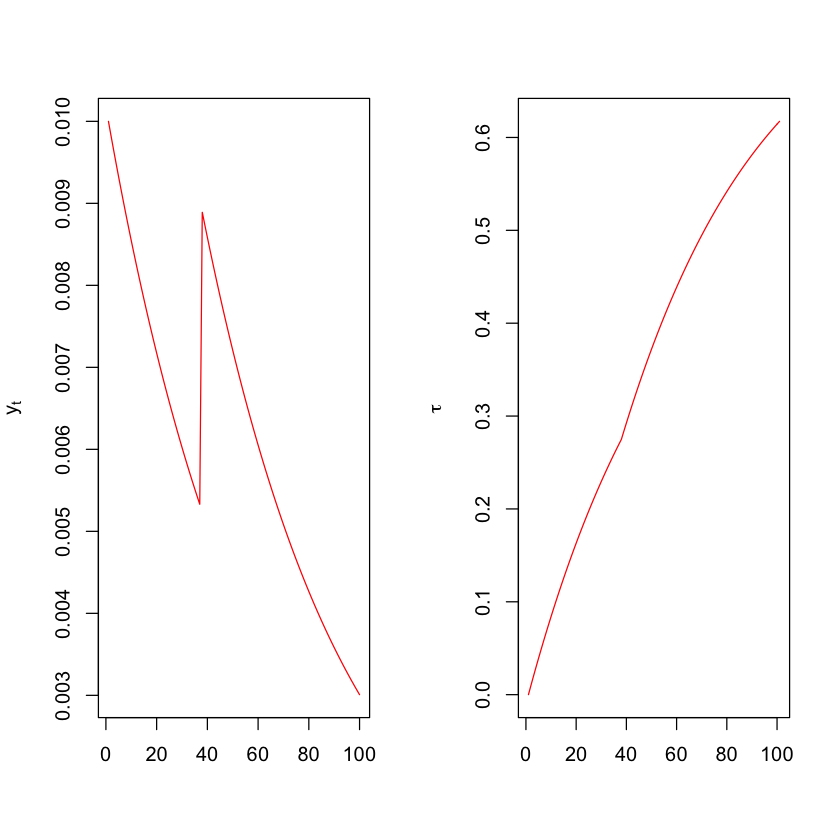

In [38]:
s <- simOU(1,100,subNIGOU) 
par(mfrow=c(1,2))
plot(diff(s),type="l",col="red",xlab=NA,ylab=expression(y[t])) 
plot(s,type="l",col="red",xlab=NA,ylab=expression(tau)) 
par(mfrow=c(1,1))

<a name="fig:timeChangeOU"></a>Figure 8: The time-change $\tau_t=\int^t y_s\,ds$

### Simulating time-changed NIG: R-code

The R library fBasics has a function to generate NIG random variables.
We simulate the time-changed NIG process by generating
$NIG(\alpha,\,\beta,\,\delta\,\Delta \tau)$ random variables at each
step where $\Delta \tau$ is the time-difference according to the chosen
stochastic clock.

In [40]:
library(fBasics) 

simNIG <- function(t,nTimes,subordinator,params){

    st <- subordinator(t,nTimes,params)  # Stochastic clock times
    delst <- diff(st) 
    x <- sapply(1:nTimes,function(i){rnig(1,alpha=params$alpha,beta=params$beta,delta=params$delta*delst[i])}) 
    return(cumsum(c(0,x))) 
}

Loading required package: timeDate
Loading required package: timeSeries


Rmetrics Package fBasics
Analysing Markets and calculating Basic Statistics
Copyright (C) 2005-2014 Rmetrics Association Zurich
Educational Software for Financial Engineering and Computational Science
Rmetrics is free software and comes with ABSOLUTELY NO WARRANTY.
https://www.rmetrics.org --- Mail to: info@rmetrics.org


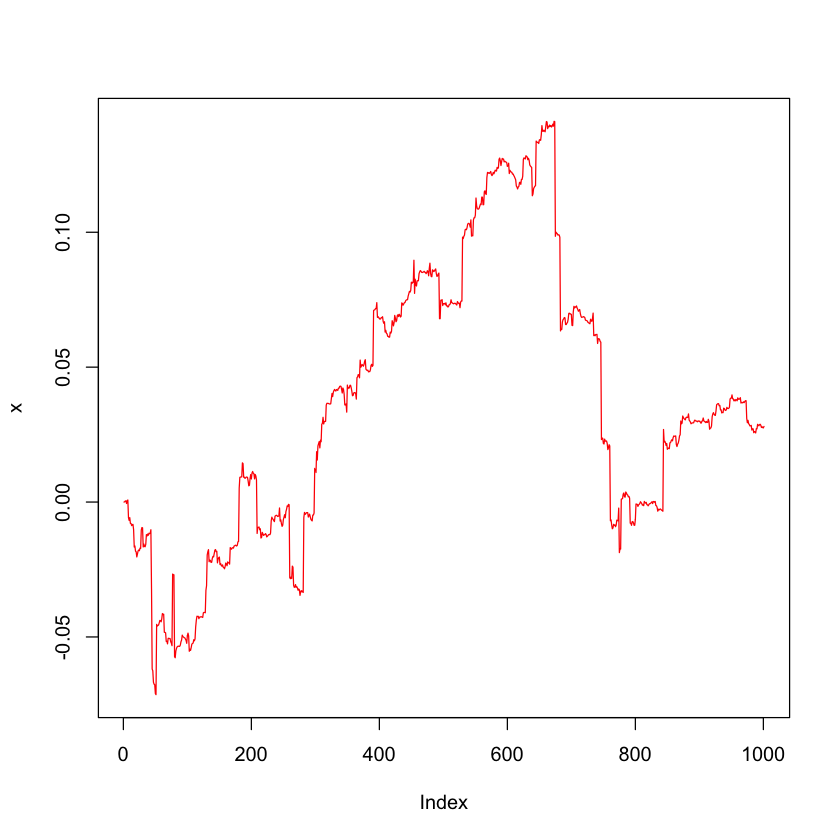

In [41]:
x <- simNIG(t=1,1000,simOU,subNIGOU)
plot(x,type="l",col="red")

### NIGOU Monte Carlo vs Analytic

The following code, when uncommented, will generate 10,000 NIGOU paths.  This code takes about 8 minutes to run on my machine.

In [54]:
#system.time(xNIGOU <- t(sapply(1:10000,function(i){simNIG(t=1,1000,simOU,subNIGOU)})))

Alternatively, you can use the following presimulated time-changed NIGOU paths for exotic option valuation.  You can download the datafile from here: https://drive.google.com/file/d/0B7j7JiZG5FMvajFjNWs4MHlTcG8/view?usp=sharing. Then move the file to your working directory. 

In [57]:
load("pathsNIGOU.rData") 
xNO <- xNIGOU[,1001]  

In [58]:
#Generate final stock prices
sNO <- exp(xNO);  sNO <- sNO/mean(sNO) 

# Compute implied vols. from final stock prices
kk <- seq(-.5,.5,.05)
AK <- exp(kk) 
res <- bsOut(sNO,1,AK) 

### Plot results and compare with analytic computation

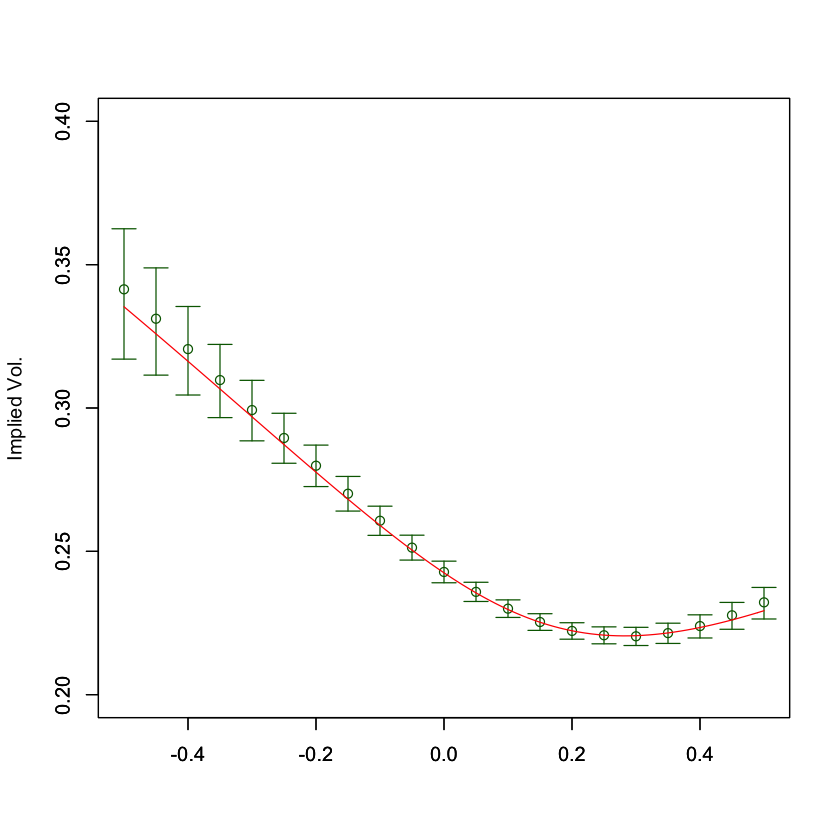

In [59]:
xrange <- c(-.5,.5);  yrange <- c(.2,.4) 
x1=.5 
plot(kk,res$BSV,xlim=xrange,ylim=yrange,xlab=NA,ylab="Implied Vol.",col="dark green")
arrows(kk,res$BSVH,kk,res$BSVL,angle=90,code=3,length=.1,col="dark green")
par(new=T)
vol <- function(k){sapply(k,function(x){bsvol(phiNIGOU(subNIGOU),x,1)})}
curve(vol(x),from=-x1,to=x1,col="red",xlim=xrange,ylim=yrange,xlab=NA,ylab=NA)

<a name="fig:nigouMC"></a>Figure 9: Here, we compare the Monte Carlo (10,000 paths) and analytic (using
characteristic function) valuations of 1 year European
options

### Valuation of the guaranteed stop-loss contract

Having determined that the simulation appears to be correct, we can
value the guaranteed stop-loss for different barrier levels.

In [60]:
gsl <- function(path,b){
if(min(path)<= b){ 
    tau <- min(which(path<=b))  # Barrier is hit at this point
    tmp <- b-path[tau]  # Jump in price
}
else tmp <- 0 
return(tmp) 
}

Generate NIGOU sample paths:

In [61]:
sNIGOU <- exp(xNIGOU)

Now plot value of guaranteed stop-loss as a function of barrier level:

    

In [62]:
gslVal <- function(k){
 tmp <- apply(sNIGOU,1,function(x){gsl(x,k)}) 
 return(mean(tmp)) 
}
bb <- c(seq(0.8,.99,0.01),.995,.999,.9999) 
y <- sapply(bb,gslVal) 

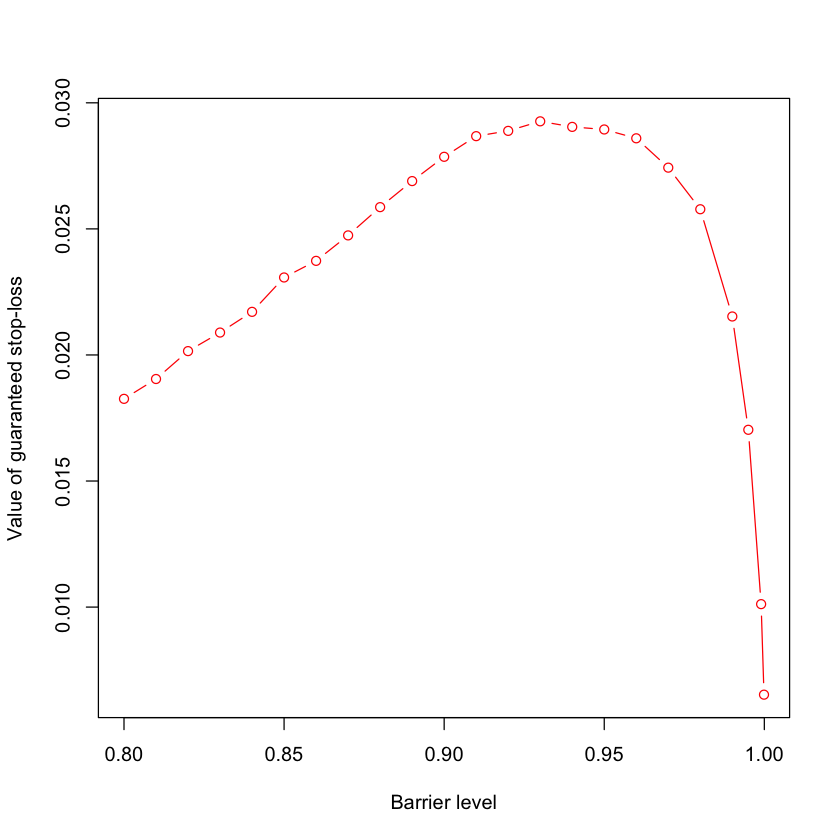

In [63]:
plot(bb,y,type="b",col="red",xlab="Barrier level", ylab="Value of guaranteed stop-loss")

<a name="fig:gslVal"></a>Figure 10: Value of the guaranteed stop-loss contract for different barrier levels

-   <span>Note the unreasonably large value under NIGOU!</span>

### The NIGOU sample path with the biggest jump

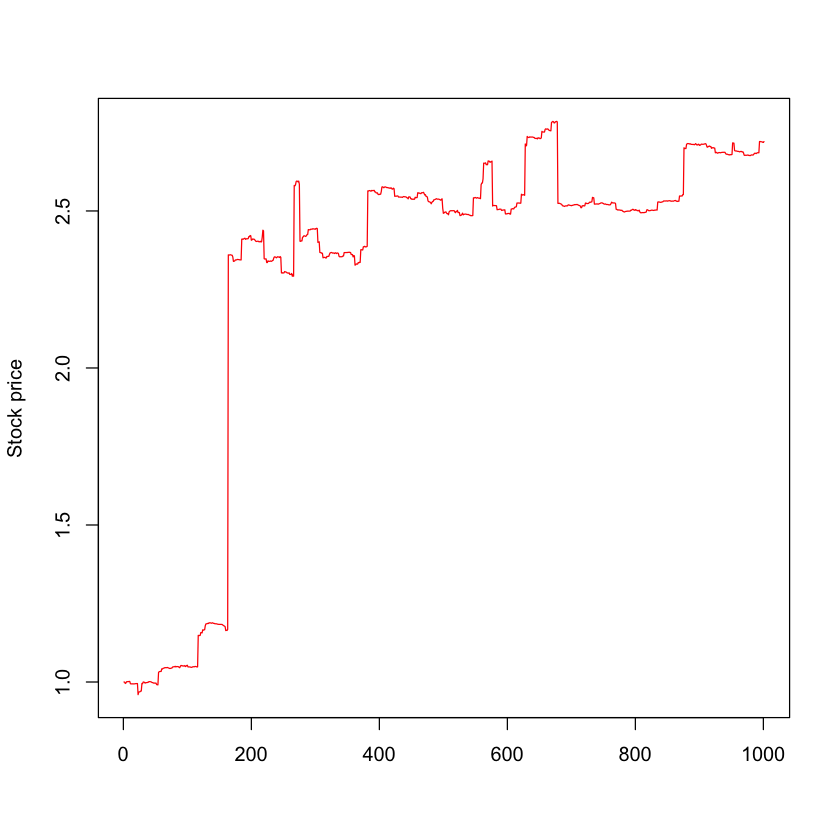

In [64]:
dNO <- apply(sNIGOU,1,diff)  # Compute differences
tmp <- apply(t(dNO),1,function(x){max(x)}) 
worst <- which(tmp==max(tmp)) 
plot(sNIGOU[worst,],col="red",type="l",ylab="Stock price",xlab=NA)

<a name="fig:nigouWorst"></a>Figure 11: The sample path with the biggest jump

-   <span>That’s a big jump!</span>

### The NIGOU sample path with the biggest negative jump

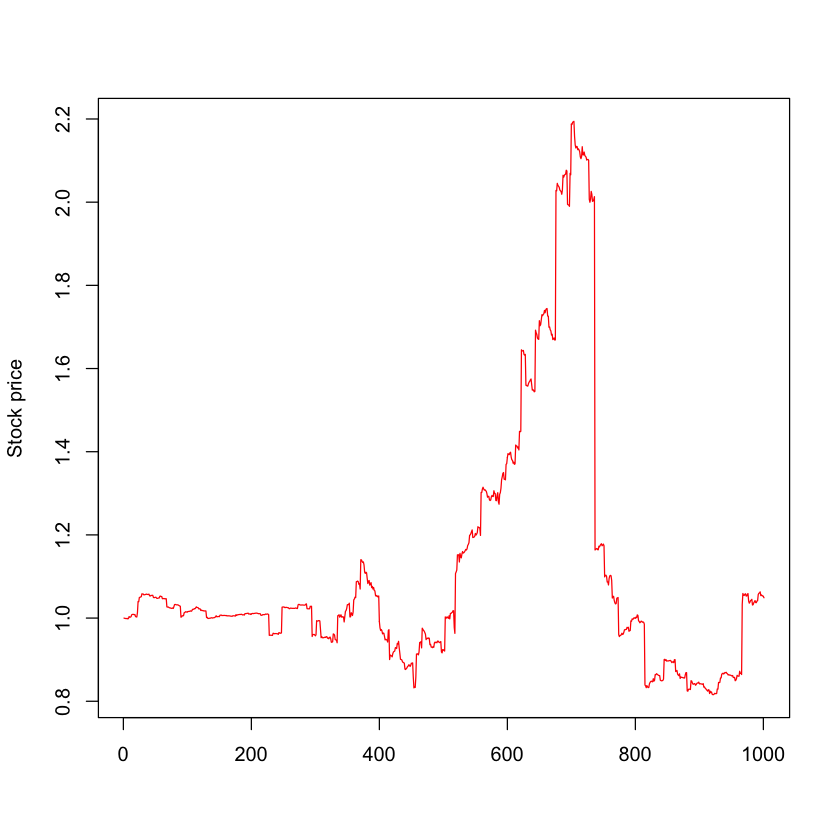

In [65]:
tmp <- apply(t(dNO),1,function(x){min(x)}) 
worst <- which(tmp==min(tmp)) 
plot(sNIGOU[worst,],col="red",type="l",ylab="Stock price",xlab=NA)

<a name="fig:nigouWorstNeg"></a>Figure 12: The sample path with the biggest negative jump

-   <span>Ouch!</span>

### Relationship between pricing measure and physical measure

-   <span>If price paths are continuous, Girsanov links the physical measure $\mathbb{P}$
    and pricing measure $\mathbb{Q}$ through a change of drift. </span>

    -   <span>In particular, $\mathbb{P}$ and $\mathbb{Q}$ price paths
        are qualitatively similar.</span>


-   <span>If there are jumps, the relationship between $\mathbb{P}$ and $\mathbb{Q}$ is not so constrained.</span>
    - Afficionados of jumps see this as an advantage:  Even if there are no huge jumps in the physical measure, there can be huge jumps in the pricing measure.

-   <span>I argue that because dealers need to delta-hedge large
    portfolios of exotic derivatives at the margin, there should be no
    significant qualitative difference between price paths under the
    statistical and risk-neutral measures.</span>

    -   <span>Pricing of hypothetical contracts such as the guaranteed
        stop-loss impose this.</span>


-   <span>This excludes processes with crazy jumpy paths such as
    NIGOU.</span>

    -   <span>For indices at least, price paths should be mostly
        diffusion-like.</span>

### Notable quotes


A quote from [Schoutens et al.]<sup id="cite_ref-Schoutens" class="reference"><a href="#cite_note-Schoutens"><span>[</span>5<span>]</span></a></sup>:
>The conclusion is that great care should be taken when employing
attractive fancy-dancy models to price (or even more important, to
evaluate hedge parameters for) exotics.

and a quote from page 495 of [Cont and Tankov]<sup id="cite_ref-ContTankov" class="reference"><a href="#cite_note-ContTankov"><span>[</span>2<span>]</span></a></sup>:

>... the Bates model appears to be at the same time the simplest and the
most flexible of the models.

Note that the Bates model is what we call SVJ.

### References

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>

  <li id="cite_note-CarrMadan"><span class="mw-cite-backlink"><b><a href="#cite_ref-CarrMadan">^</a></b></span> Peter Carr and Dilip Madan, Option valuation using the Fast Fourier
Transform, <span>*Journal of Computational Finance*</span>
<span>**2**</span>(4), 61–73 (1999).</li>

  <li id="cite_note-ContTankov"><span class="mw-cite-backlink"><b><a href="#cite_ref-ContTankov">^</a></b></span> Rama Cont and Peter Tankov, <span>*Financial Modelling with Jump
Processes*</span>, Chapman & Hall/CRC Financial Mathematics Series
(2003).</li>

  <li id="cite_note-TVS"><span class="mw-cite-backlink"><b><a href="#cite_ref-TVS">^</a></b></span>   Jim Gatheral,  <span>*The Volatility Surface: A Practitioner's Guide*</span>, John Wiley and Sons, Hoboken, NJ (2006).</li>

  <li id="cite_note-Lewis"><span class="mw-cite-backlink"><b><a href="#cite_ref-Lewis">^</a></b></span> Alan L. Lewis, *Option Valuation under Stochastic Volatility with
Mathematica Code*, Finance Press: Newport Beach, CA (2000).</li>

  <li id="cite_note-Schoutens"><span class="mw-cite-backlink"><b><a href="#cite_ref-Schoutens">^</a></b></span>   Wim Schoutens, Erwin Simons, and Jurgen Tistaert, <span>A perfect
calibration! Now what?</span>, <span>*Wilmott Magazine*</span>,
<span>**2**</span> 66–78 (March 2004).</li>

</ol>